## Preparation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.4.0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.3.3
numpy 1.18.4
pandas 1.1.5
sklearn 0.24.0
tensorflow 2.4.0
tensorflow.keras 2.4.0


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.allow_soft_placement=True
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


## Normalization

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform( x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
# Number of channels is 1!

## Modeling

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='selu',
                              input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

## Training

In [6]:
logdir = './conv-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]

history = model.fit(x_train_scaled, y_train,
                    epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/10
1719/1719 [==============================] - 32s 12ms/step - loss: 0.6149 - accuracy: 0.7766 - val_loss: 0.3357 - val_accuracy: 0.8800
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3154 - accuracy: 0.8844 - val_loss: 0.2755 - val_accuracy: 0.8980
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2529 - accuracy: 0.9070 - val_loss: 0.2801 - val_accuracy: 0.8938
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2182 - accuracy: 0.9224 - val_loss: 0.2604 - val_accuracy: 0.9042
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1870 - accuracy: 0.9316 - val_loss: 0.2288 - val_accuracy: 0.9186
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1681 - accuracy: 0.9390 - val_loss: 0.2389 - val_accuracy: 0.9100
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1418 - accuracy: 0.9501 - val_loss: 0.2421 - val_accurac

## Evaluation

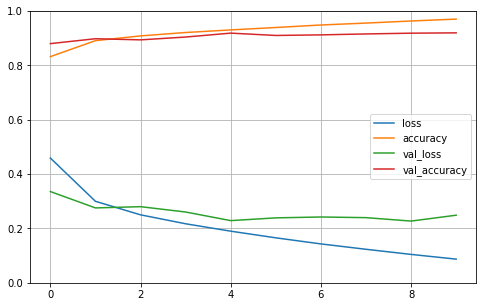

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [9]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.2745276689529419, 0.9138000011444092]